# Building a Bigram Model

In this document, we'll build a simple bigram model to create fake Greek Mythology names.
We will use tokens as the smallest possible subwords, i.e. inidividual characters. The bigram model will consist of first tokenizing the corpus, and then using an embedding (i.e. a table with one vector for each unique character) as the logits of the next token prediction.


### 0. Importing Libraries

We'll use PyTorch to build our Bigram model.

In [1]:
import requests
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import regex as re

### 1. Download Corpus

Reading the file with the names of characters in Greek Mythology as a single string.

In [2]:
path = 'data/greek_gods.txt'

with open(path, 'r') as f:
    corpus = f.read()

corpus[:50]

'Aphrodite\nApollo\nAres\nArtemis\nAthena\nDemeter\nDiony'

Adding the special character '_' to denote the start and end of a name

In [3]:
corpus = re.sub(r'\n', '_', corpus)
corpus = '_' + corpus + '_'

In [4]:
corpus[:20]

'_Aphrodite_Apollo_Ar'

### 2. Vocabulary Building and Tokenization

For simplicity, we'll use characters as tokens. 

So, first we'll extract all unique characters and use it as our vocabulary.

In [5]:
vocabulary = sorted(list(set(corpus)))

print('Vocabulary: {}'.format(''.join(vocabulary)))
print(f'\nSize of vocabulary is {len(vocabulary)}')

Vocabulary:  ABCDEGHIKLMNOPRSTUZ_abcdeghiklmnoprstuxyzë

Size of vocabulary is 43


We'll need a function to tokenize and detokenize the data.

- **tokenize**: 'abc' $\rightarrow$ [1,2,3]
- **detokenize**: [1,2,3] $\rightarrow$ 'abc'

In [6]:
char2idx = {char:i for i, char in enumerate(vocabulary)}
idx2char = {i:char for i, char in enumerate(vocabulary)}

tokenize = lambda chars: [char2idx[char] for char in chars]
detokenize = lambda idxs: ''.join([idx2char[int(idx)] for idx in idxs])

In [7]:
tokenize('abc')

[21, 22, 23]

In [8]:
detokenize(tokenize('abc'))

'abc'

Finally, we'll tokenize the entire corpus and transform it into a pytorch 1-dimensional tensor.

In [9]:
corpus_tk = torch.tensor(tokenize(corpus), dtype=torch.long)
corpus_tk[:10]

tensor([20,  1, 34, 27, 35, 33, 24, 28, 37, 25])

### 3. Creating the Training Set


Building the training set with a 1-char context (bigram model)

In [10]:
x = corpus_tk[:-1]
y = corpus_tk[1:]
train = TensorDataset(x, y)

Showing the input (previous character) and target (next character) in our dataset.

In [11]:
list(zip(detokenize(x[:15]), detokenize(y[:15])))

[('_', 'A'),
 ('A', 'p'),
 ('p', 'h'),
 ('h', 'r'),
 ('r', 'o'),
 ('o', 'd'),
 ('d', 'i'),
 ('i', 't'),
 ('t', 'e'),
 ('e', '_'),
 ('_', 'A'),
 ('A', 'p'),
 ('p', 'o'),
 ('o', 'l'),
 ('l', 'l')]

### 4. Building Bigram Model

In [12]:
class BigramModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    # Uses the embedding as a logit
    def forward(self, x):
        return self.emb(x)

    # It generates n tokens using the model
    def generate(self, n_max=20):

        # Pick first token randomly
        token = torch.tensor(tokenize('_'))

        # Append it to the result
        story = []

        # Iterate n times
        for _ in range(n_max):

            # Apply model to get logits
            logits = self.forward(token)

            # Use softmax to convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample next token
            token = torch.multinomial(probs, 1)[0]

            if detokenize(token)=='_':
                break
                
            # Append it to the result
            story.append(token.tolist()[0])

        # Return characters instead of ids
        return detokenize(story)

In [13]:
bm = BigramModel(len(vocabulary))

Initial generation of 10 names. They are generated autoregressively character by character until '_' is found.

In [14]:
for _ in range(10):
    print(bm.generate())

CrZmrddteLEDHPAmykOm
menOTly phRUOIIbLOxN
RiZlNOmHSlmrDeLbldpë
o im
aUIR Ag unylBzoNeNoD
NtaUAGGPazcbgxHy
uIkkSAAylxRkZamNzcOm
CouZtKrkAUKxSozcëcmc
CGKspptCNBRuIxpx
Cunleutr


Defining loss and optimizer

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bm.parameters(), lr=1e-3)

Defining Dataloader for the training set.

In [16]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)

Training the model (i.e. optimizing embedding table).

In [17]:
n_epochs = 500
loss_train = []

# For 'n_epochs':
for i in tqdm(range(n_epochs)):

    # Optimize parameters batch-by-batch
    bm.train()
    for x,y in train_dataloader:

        y_pred = bm(x)

        optimizer.zero_grad()

        loss = loss_fn(y_pred, y)
        loss_train.append(loss.item())
        loss.backward()
        
        optimizer.step()

    # After training set has been fully fed, get test error and print 
    bm.eval()
    if i%int(n_epochs/5)==0:
        # Train
        loss_train = np.mean(loss_train)
        print(f'train loss: {loss_train}')
        print()
        
        loss_train = []

  2%|▊                                          | 9/500 [00:00<00:11, 42.42it/s]

train loss: 4.1313611387132525



 22%|█████████                                | 111/500 [00:01<00:06, 57.94it/s]

train loss: 2.51475383857349



 41%|████████████████▉                        | 207/500 [00:03<00:05, 58.05it/s]

train loss: 2.1121503291688524



 62%|█████████████████████████▎               | 309/500 [00:05<00:03, 57.94it/s]

train loss: 2.1020765314338443



 82%|█████████████████████████████████▋       | 411/500 [00:07<00:01, 58.50it/s]

train loss: 2.1012610861202616



100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.55it/s]


### 5. Creating New Greek Mythology Names

Now, we build 10 more names with the trained model.

In [18]:
for _ in range(10):
    print(bm.generate())

Pamois
An
Eus
Thuponaes
Crarteropoiropharade
Pysbo
Thanalos
Aca
Aunde
Pheleocyoxi


### 5. Conclusion

The names now are much more convincing than the ones before training, which goes to show that the model has learned something about the structure of a Greek Mythology name, like capializing the first letter of the name, and alternating consonants and vowels.

Keep in mind that all of this was learned from a simple context window of a single character. We can even build a heatmap showing the probability distribution over the next tokens given the current token, as done below.

In [19]:
# Each column represents the current token, and each row, the next token
connections = np.zeros([len(vocabulary), len(vocabulary)])

for i, char in enumerate(vocabulary):
    token = torch.tensor(tokenize(char))
    logits = bm.forward(token)
    probs = F.softmax(logits, dim=-1)
    connections[:,i] = probs.tolist()[0]

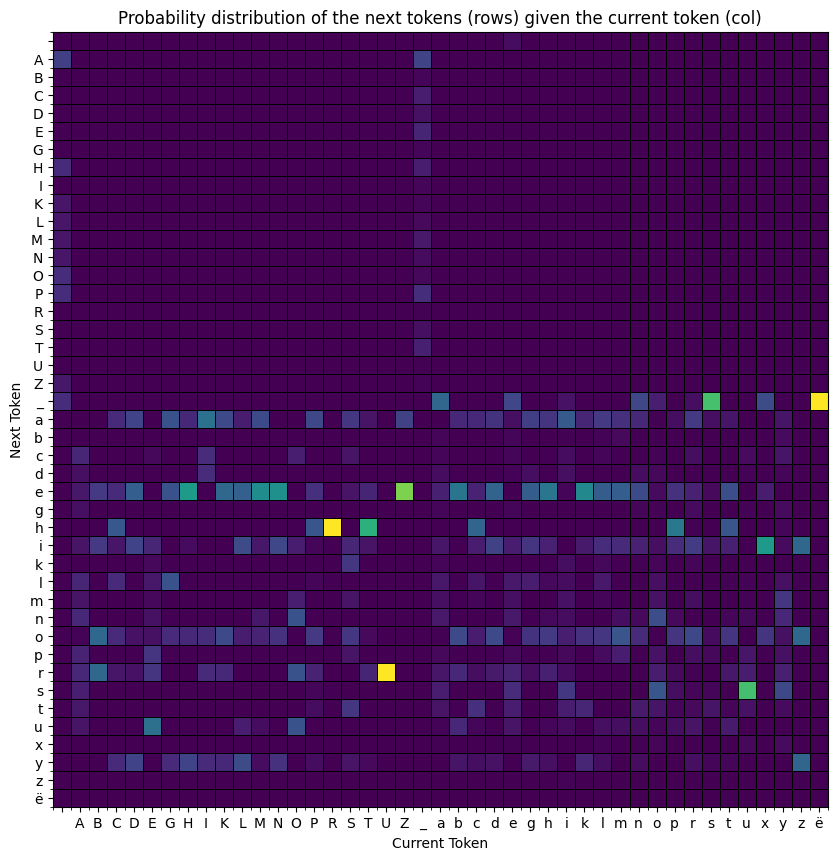

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
plt.imshow(connections, cmap='viridis')
plt.ylabel('Next Token')
plt.yticks(ticks=np.arange(len(vocabulary)), labels=vocabulary)
plt.xlabel('Current Token')
plt.xticks(ticks=np.arange(len(vocabulary)), labels=vocabulary)

plt.xticks(np.arange(-0.5, len(vocabulary), 1), minor=True)
plt.yticks(np.arange(-0.5, len(vocabulary), 1), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.7)
plt.title('Probability distribution of the next tokens (rows) given the current token (col)')
plt.show()